In [80]:
import pandas as pd

In [81]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [82]:
from utils.data_funcs import *

In [83]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

# Model Types
1. Takes yesterday's active cases, date of year, and time since closure and predicts daily case numbers for today. Starting with an initial day seed, we can propogate forward the daily cases and analyze how different implementation dates affect case numbers.

2. Takes yesterday's active cases and time since closure and predicts daily case numbers for today. Like model type 1, we can start with an initial day seed and propogate forward the daily cases. However, here we have the notion of a general policy affect. This model can perhaps alter the initial number of cases to gauge policy effectiveness when implemented at different heights of pandemic.

# Model Training Functions

In [171]:
def cv_xgboost(input_dmatrix, full_grid):
    # Define parameter grid
    if (full_grid):
        grid = {
            'objective': ['reg:squarederror'],
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.3, 0.6, 0.8],
            'learning_rate': [0.05, 0.1, 0.15],
            'alpha': [1, 5, 10]
        }
    else:
        grid = {
            'objective': ['reg:squarederror'],
            'min_child_weight': [5, 10],
            'gamma': [0.5, 1.5],
            'subsample': [0.6, 1.0],
            'colsample_bytree': [0.3, 0.8],
            'learning_rate': [0.05, 0.15],
            'alpha': [10]
        }
        param_grid = ParameterGrid(grid)
    
    # Search over parameter grid
    min_params = None
    min_cv = None
    min_boost = None
    for params in list(param_grid):
        for num_bst_rnds in [25]:
            # Cross validate for optimal parameters
            cv_results = xgb.cv(dtrain=input_dmatrix, params=params, nfold=5,
                                num_boost_round=num_bst_rnds, early_stopping_rounds=10,
                                metrics="rmse", as_pandas=True, seed=123)
            if (not min_cv) or (cv_results["test-rmse-mean"].iloc[-1] < min_cv):
                min_cv = cv_results["test-rmse-mean"].iloc[-1]
                min_params = params.copy()
                min_boost = num_bst_rnds
                
    return min_params, min_boost, min_cv

def plot_feature_importances(xg_reg):
    xgb.plot_importance(xg_reg)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    
    xgb.plot_importance(xg_reg, importance_type='gain')
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    
    xgb.plot_importance(xg_reg, importance_type='cover')
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()

# Model 1 Input Dataframe 

In [255]:
# Get state policy data
input_df = get_state_policy_data(fill=True)

# Keep relevant columns
policy_of_interest = policies[0]
input_df = input_df[['region_name', 'date', policy_of_interest]]

/home/beau/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [256]:
# Add days since policy change
input_df.loc[:, 'days_since_more_strict'] = time_elapsed_since_policy_change(input_df, 
                                                                             policy_of_interest,
                                                                             type_change='more_strict')

In [257]:
# Rename region_name to state
input_df.rename(columns={'region_name': 'state'}, inplace=True)

# Get US daily case data for 50 states
us_state_daily = get_state_covid_daily_data()
not_states = ['District of Columbia', 'Guam', 'Northern Mariana Islands','Puerto Rico', 'Virgin Islands']
us_state_daily_50 =  us_state_daily[~(us_state_daily.state.isin(not_states))]

In [258]:
# Merge daily cases with input df
input_df = us_state_daily_50.merge(input_df, how='left', on=['state', 'date'] )

# Get cumulative cases and add as col to input df
input_df['yesterdays_active_cases'] = get_yesterdays_active_cases(input_df, window=15)

# Merge pop density with input df
input_df = input_df.merge(get_pop_density_by_state_data(), on='state', how='left')

# Merge wage data with input df
input_df = input_df.merge(get_scaled_wages_data()[['state', 'scaled_median_income']], on=['state'], how='left')

# Merge political data with input df
input_df = input_df.merge(get_political_data(), on=['state'], how='left')

In [259]:
# Binary encode state names
# alpha_ordered_states = input_df.state.unique()
# alpha_ordered_states.sort()
# binary_state_encoded_df = binary_encode_category(alpha_ordered_states, 'state')
# input_df = input_df.merge(binary_state_encoded_df, on='state', how='left')

In [260]:
# Adding day of year
input_df['day'] = input_df.date.dt.dayofyear + 365 * (input_df.date.dt.year - 2020)

In [261]:
# Grab time window to split training and test data
date_start = "2020-01-01"
date_end = "2020-12-31"
train_df = input_df.loc[(input_df['date'] >= date_start) & 
                        (input_df['date'] <= date_end)].copy()
test_df = input_df.loc[(input_df['date'] > date_end)].copy()

# Drop unused cols
train_df = train_df.drop(columns=['state', 'deaths', 'date'])
test_df = test_df.drop(columns=['state', 'deaths', 'date'])

In [262]:
# Get input and output for training
x_train_df = train_df.loc[:, train_df.columns != 'cases'].copy()
y_train_df = train_df[['cases']].copy()

# Get input and output for testing
x_test_df = test_df.loc[:, test_df.columns != 'cases'].copy()
y_test_df = test_df[['cases']].copy()

# Model 1 XGBoost Training

In [263]:
# Data DMatrix is special datatype used by XGboost, quicker performance
train_data_dmatrix = xgb.DMatrix(data=x_train_df, label = y_train_df)
test_data_dmatrix = xgb.DMatrix(data=x_test_df, label = y_test_df)

In [264]:
min_params, min_boost, min_cv = cv_xgboost(train_data_dmatrix, full_grid = False)

In [265]:
xg_reg = xgb.train(params=min_params, dtrain=train_data_dmatrix, num_boost_round = min_boost)

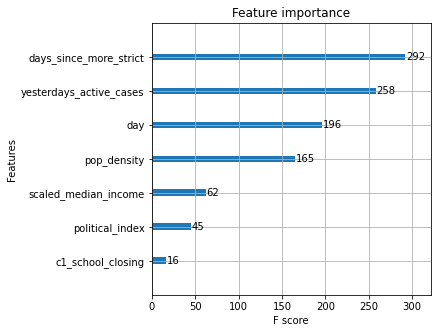

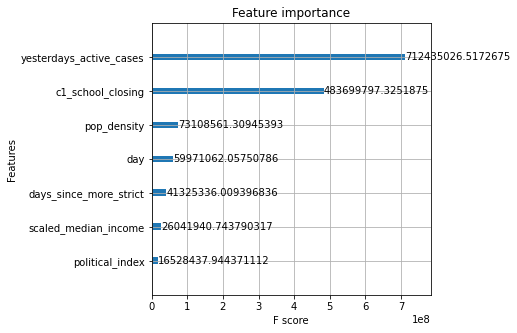

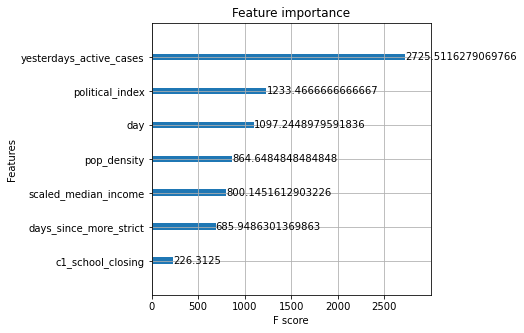

In [266]:
plot_feature_importances(xg_reg)

In [267]:
print("RMSE Error of Best Parameter Run: {}".format(min_cv))
print("RMSE Error of Best Param Model on Test Set: {}".format(np.sqrt(mean_squared_error(
    y_test_df.to_numpy(), xg_reg.predict(test_data_dmatrix)))))

RMSE Error of Best Parameter Run: 1012.2978271999998
RMSE Error of Best Param Model on Test Set: 2739.4083470062424


# Model 1 Simulation

In [292]:
def m1_plot_policy_trend(xgb_model, seed, initial_cases):
    results = [sum(initial_cases)]
    days = [int(seed['day'].iloc[0]) - 1]
    
    curr_day = seed.copy()
    case_window = initial_cases.copy()
    for i in range(50):
        new_cases = xgb_model.predict(xgb.DMatrix(data=curr_day))[0]
        days.append(curr_day.loc[0, 'day'])
        case_window.append(new_cases)
        curr_day['yesterdays_active_cases'] = (curr_day.loc[0, 'yesterdays_active_cases'] - 
                                               case_window.pop(0) + new_cases)
        curr_day['day'] = curr_day.loc[0, 'day'] + 1
        curr_day['days_since_more_strict'] = curr_day.loc[0, 'days_since_more_strict'] + 1
        results.append(sum(case_window))
        
    peak_active_cases = max(results)
    initial_active_cases = sum(initial_cases)
    print(peak_active_cases)
    
    plt.plot(days, results)

In [301]:
temp2 = get_state_policy_data(fill = True)
temp2.loc[(temp2.region_name == 'Washington') & (temp2.date >= "2020-03-01") & (temp2.date <= "2020-03-30")]

/home/beau/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,country_name,country_code,region_name,region_code,jurisdiction,date,c1_school_closing,c1_flag,c2_workplace_closing,c2_flag,...,stringency_index,stringency_index_for_display,stringency_legacy_index,stringency_legacy_index_for_display,government_response_index,government_response_index_for_display,containment_health_index,containment_health_index_for_display,economic_support_index,economic_support_index_for_display
125216,United States,USA,Washington,US_WA,STATE_TOTAL,2020-03-01,0.0,0.0,0.0,0.0,...,11.11,11.11,16.67,16.67,13.54,13.54,15.48,15.48,0.0,0.0
125217,United States,USA,Washington,US_WA,STATE_TOTAL,2020-03-02,0.0,0.0,0.0,0.0,...,13.89,13.89,20.24,20.24,15.10,15.10,17.26,17.26,0.0,0.0
125218,United States,USA,Washington,US_WA,STATE_TOTAL,2020-03-03,0.0,0.0,0.0,0.0,...,13.89,13.89,20.24,20.24,15.10,15.10,17.26,17.26,0.0,0.0
125219,United States,USA,Washington,US_WA,STATE_TOTAL,2020-03-04,0.0,0.0,1.0,0.0,...,20.37,20.37,32.14,32.14,18.75,18.75,21.43,21.43,0.0,0.0
125220,United States,USA,Washington,US_WA,STATE_TOTAL,2020-03-05,0.0,0.0,1.0,0.0,...,20.37,20.37,32.14,32.14,18.75,18.75,21.43,21.43,0.0,0.0
125221,United States,USA,Washington,US_WA,STATE_TOTAL,2020-03-06,0.0,0.0,1.0,0.0,...,20.37,20.37,32.14,32.14,18.75,18.75,21.43,21.43,0.0,0.0
125222,United States,USA,Washington,US_WA,STATE_TOTAL,2020-03-07,0.0,0.0,1.0,0.0,...,20.37,20.37,32.14,32.14,18.75,18.75,21.43,21.43,0.0,0.0
125223,United States,USA,Washington,US_WA,STATE_TOTAL,2020-03-08,0.0,0.0,1.0,0.0,...,20.37,20.37,32.14,32.14,18.75,18.75,21.43,21.43,0.0,0.0
125224,United States,USA,Washington,US_WA,STATE_TOTAL,2020-03-09,0.0,0.0,1.0,0.0,...,20.37,20.37,32.14,32.14,18.75,18.75,21.43,21.43,0.0,0.0
125225,United States,USA,Washington,US_WA,STATE_TOTAL,2020-03-10,0.0,0.0,1.0,0.0,...,20.37,20.37,32.14,32.14,22.40,22.40,23.81,23.81,12.5,12.5


In [297]:
temp = get_state_covid_daily_data()
temp.loc[(temp.state == 'Washington') & (temp.date >= "2020-03-01") & (temp.date <= "2020-03-30")]

,state,date,cases,deaths
19485,Washington,2020-03-01,7.0,2.0
19486,Washington,2020-03-02,6.0,3.0
19487,Washington,2020-03-03,9.0,4.0
19488,Washington,2020-03-04,15.0,1.0
19489,Washington,2020-03-05,28.0,0.0
19490,Washington,2020-03-06,11.0,1.0
19491,Washington,2020-03-07,24.0,4.0
19492,Washington,2020-03-08,31.0,3.0
19493,Washington,2020-03-09,38.0,3.0
19494,Washington,2020-03-10,100.0,2.0


26418.472412109375


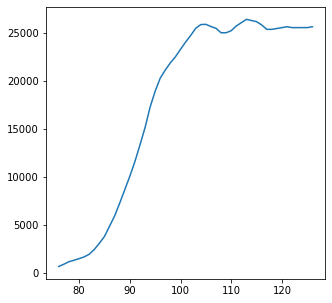

In [305]:
# Define initial seed
mean_pd = get_pop_density_by_state_data().mean().iloc[0]
mean_wage = get_scaled_wages_data()[['state', 'scaled_median_income']].mean().iloc[0]
mean_pol = get_political_data().mean().iloc[0]
strictness = 2
imp_day = pd.to_datetime("2020-03-17").dayofyear
days_since = 0
initial_cases = list(temp.loc[(temp.state == 'Washington') & (temp.date >= "2020-03-01") & (temp.date <= "2020-03-30")].cases.values)[1:15]
act_cases = sum(initial_cases)
seed = pd.DataFrame([strictness, days_since, act_cases, mean_pd, mean_wage, mean_pol, imp_day]).T
seed.columns = x_train_df.columns

# Use seed to plot trend
m1_plot_policy_trend(xg_reg, seed, initial_cases)

26710.515625


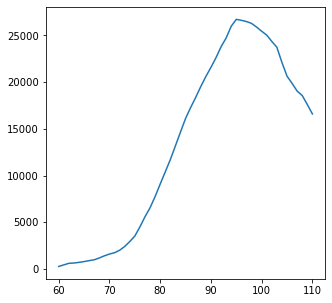

In [295]:
# Define initial seed
mean_pd = get_pop_density_by_state_data().mean().iloc[0]
mean_wage = get_scaled_wages_data()[['state', 'scaled_median_income']].mean().iloc[0]
mean_pol = get_political_data().mean().iloc[0]
strictness = 2
imp_day = pd.to_datetime("2020-03-10").dayofyear
days_since = 0
initial_cases = list(temp.loc[(temp.state == 'Washington') & (temp.date >= "2020-03-01") & (temp.date <= "2020-03-30")].cases.values)[0:14]
act_cases = sum(initial_cases)
seed = pd.DataFrame([strictness, days_since, act_cases, mean_pd, mean_wage, mean_pol, imp_day]).T
seed.columns = x_train_df.columns

# Use seed to plot trend
m1_plot_policy_trend(xg_reg, seed, initial_cases)

24986.356201171875


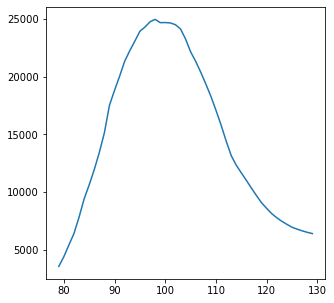

In [296]:
# Define initial seed
mean_pd = get_pop_density_by_state_data().mean().iloc[0]
mean_wage = get_scaled_wages_data()[['state', 'scaled_median_income']].mean().iloc[0]
mean_pol = get_political_data().mean().iloc[0]
strictness = 2
imp_day = pd.to_datetime("2020-03-20").dayofyear
days_since = 0
initial_cases = list(temp.loc[(temp.state == 'Washington') & (temp.date >= "2020-03-01") & (temp.date <= "2020-03-30")].cases.values)[20:30]
act_cases = sum(initial_cases)
seed = pd.DataFrame([strictness, days_since, act_cases, mean_pd, mean_wage, mean_pol, imp_day]).T
seed.columns = x_train_df.columns

# Use seed to plot trend
m1_plot_policy_trend(xg_reg, seed, initial_cases)

# Model 2 Input Dataframe

In [240]:
# Get state policy data
input_df = get_state_policy_data(fill=True)

# Keep relevant columns
policy_of_interest = policies[0]
input_df = input_df[['region_name', 'date', policy_of_interest]]

/home/beau/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [241]:
# Add days since policy change
input_df.loc[:, 'days_since_more_strict'] = time_elapsed_since_policy_change(input_df, 
                                                                             policy_of_interest,
                                                                             type_change='more_strict')

In [242]:
# Rename region_name to state
input_df.rename(columns={'region_name': 'state'}, inplace=True)

# Get US daily case data for 50 states
us_state_daily = get_state_covid_daily_data()
not_states = ['District of Columbia', 'Guam', 'Northern Mariana Islands','Puerto Rico', 'Virgin Islands']
us_state_daily_50 =  us_state_daily[~(us_state_daily.state.isin(not_states))]

In [243]:
# Merge daily cases with input df
input_df = us_state_daily_50.merge(input_df, how='left', on=['state', 'date'] )

# Get cumulative cases and add as col to input df
input_df['yesterdays_active_cases'] = get_yesterdays_active_cases(input_df, window=15)

# input_df['future_cases'] = get_future_cum_cases(input_df, window=30)

# Merge pop density with input df
input_df = input_df.merge(get_pop_density_by_state_data(), on='state', how='left')

# Merge mobility data with input df
# input_df = input_df.merge(get_at_away_6_data(), on=['date', 'state'], how='left')

# Merge wage data with input df
input_df = input_df.merge(get_scaled_wages_data()[['state', 'scaled_median_income']], on=['state'], how='left')

# Merge political data with input df
input_df = input_df.merge(get_political_data(), on=['state'], how='left')

In [244]:
# Binary encode state names
# alpha_ordered_states = input_df.state.unique()
# alpha_ordered_states.sort()
# binary_state_encoded_df = binary_encode_category(alpha_ordered_states, 'state')
# input_df = input_df.merge(binary_state_encoded_df, on='state', how='left')

In [246]:
# Grab time window to split training and test data
date_start = "2020-01-01"
date_end = "2020-12-31"
test_states = list(input_df.state.unique())[1:16]
train_df = input_df.loc[(input_df['date'] >= date_start) & 
                        (input_df['date'] <= date_end) &
                        (~input_df.state.isin(test_states))].copy()
test_df = input_df.loc[(input_df['date'] >= date_start) & 
                        (input_df['date'] <= date_end) &
                        (input_df.state.isin(test_states))].copy()

# test_df = input_df.loc[(input_df['date'] > date_end)].copy()

# Drop unused cols
train_df = train_df.drop(columns=['state', 'deaths', 'date'])
test_df = test_df.drop(columns=['state', 'deaths', 'date'])

In [247]:
# Get input and output for training
x_train_df = train_df.loc[:, train_df.columns != 'cases'].copy()
y_train_df = train_df[['cases']].copy()

# Get input and output for testing
x_test_df = test_df.loc[:, test_df.columns != 'cases'].copy()
y_test_df = test_df[['cases']].copy()

# Model 2 XGBoost Training

In [248]:
# Data DMatrix is special datatype used by XGboost, quicker performance
train_data_dmatrix = xgb.DMatrix(data=x_train_df, label = y_train_df)
test_data_dmatrix = xgb.DMatrix(data=x_test_df, label = y_test_df)

In [249]:
min_params, min_boost, min_cv = cv_xgboost(train_data_dmatrix, full_grid = False)

In [250]:
xg_reg = xgb.train(params=min_params, dtrain=train_data_dmatrix, num_boost_round = min_boost)

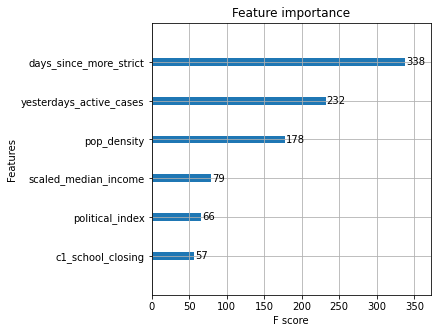

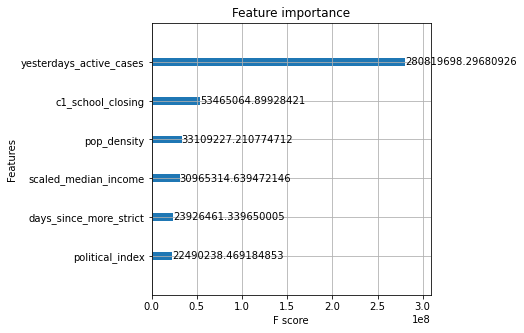

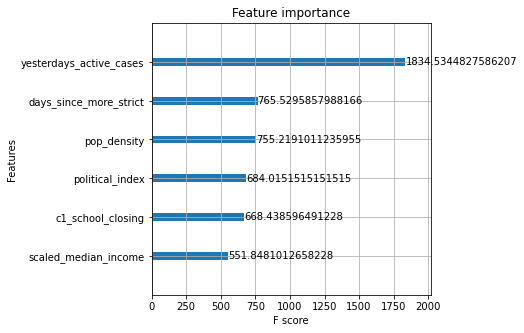

In [251]:
plot_feature_importances(xg_reg)

In [252]:
print("RMSE Error of Best Parameter Run: {}".format(min_cv))
print("RMSE Error of Best Param Model on Test Set: {}".format(np.sqrt(mean_squared_error(
    y_test_df.to_numpy(), xg_reg.predict(test_data_dmatrix)))))

RMSE Error of Best Parameter Run: 921.016455
RMSE Error of Best Param Model on Test Set: 2216.978620234034


# Model 2 Simulation

In [159]:
def m2_plot_policy_trend(xgb_model, seed, initial_cases):
    results = initial_cases.copy()
    days = list(range(-15, 0))
    day = 0
    curr_day = seed.copy()
    for i in range(30):
        new_cases = xgb_model.predict(xgb.DMatrix(data=curr_day))[0]
        results.append(new_cases)
        days.append(day)
        initial_cases.append(new_cases)
        curr_day['yesterdays_active_cases'] = (curr_day.loc[0, 'yesterdays_active_cases'] - 
                                               initial_cases.pop(0) + new_cases)
        day += 1
        curr_day['days_since_more_strict'] = curr_day.loc[0, 'days_since_more_strict'] + 1
    
    plt.plot(days, results)

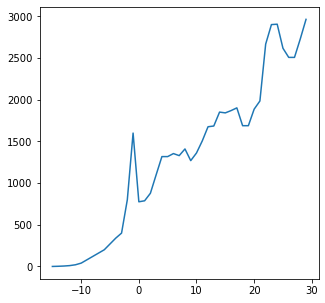

In [160]:
mean_pd = get_pop_density_by_state_data().mean().iloc[0]
mean_wage = get_scaled_wages_data()[['state', 'scaled_median_income']].mean().iloc[0]
mean_pol = get_political_data().mean().iloc[0]
strictness = 2
days_since = 0
initial_cases = [0, 2, 5, 10, 20, 40, 80, 120, 160, 200, 270, 340, 400, 800, 1600]
act_cases = sum(initial_cases)
seed = pd.DataFrame([strictness, days_since, act_cases, mean_pd, mean_wage, mean_pol]).T
seed.columns = x_train_df.columns

m2_plot_policy_trend(xg_reg, seed, initial_cases)

In [166]:
temp = input_df.copy()
display(temp.loc[temp.state == 'Texas'])
temp = input_df.loc[~input_df.state.isin(['Texas'])].copy()
temp.loc[temp.state == 'Texas']

,state,date,cases,deaths,c1_school_closing,days_since_more_strict,yesterdays_active_cases,pop_density,scaled_median_income,political_index
16198,Texas,2020-02-12,1.0,0.0,0.0,0.0,0.0,107.95351,-0.19428,-0.089994
16199,Texas,2020-02-13,1.0,0.0,0.0,0.0,1.0,107.95351,-0.19428,-0.089994
16200,Texas,2020-02-14,0.0,0.0,0.0,0.0,2.0,107.95351,-0.19428,-0.089994
16201,Texas,2020-02-15,0.0,0.0,0.0,0.0,2.0,107.95351,-0.19428,-0.089994
16202,Texas,2020-02-16,0.0,0.0,0.0,0.0,2.0,107.95351,-0.19428,-0.089994
...,...,...,...,...,...,...,...,...,...,...
16599,Texas,2021-03-19,3971.0,169.0,2.0,131.0,70453.0,107.95351,-0.19428,-0.089994
16600,Texas,2021-03-20,2673.0,97.0,2.0,132.0,66740.0,107.95351,-0.19428,-0.089994
16601,Texas,2021-03-21,2338.0,45.0,2.0,133.0,63822.0,107.95351,-0.19428,-0.089994
16602,Texas,2021-03-22,3427.0,109.0,2.0,134.0,62527.0,107.95351,-0.19428,-0.089994


,state,date,cases,deaths,c1_school_closing,days_since_more_strict,yesterdays_active_cases,pop_density,scaled_median_income,political_index
